# Analyzing UVES Spectroscopy with Astropy

## Authors
Moritz Guenther, Miguel de Val-Borro, Emily Rice (Learning Goals & formatting)

## Learning Goals
* *Input/Output*: Read in spectral data from a list of FITS files using [astropy.io](http://docs.astropy.org/en/stable/io/fits/index.html) and [astropy.wcs](http://docs.astropy.org/en/stable/wcs/index.html)
* *Coding*: Make code reusable as a function
* *Analysis*: Analyze spectral data using [astropy.units](http://docs.astropy.org/en/stable/units/index.html),  [astropy.constants](http://docs.astropy.org/en/stable/constants/index.html), and [astropy.time](http://docs.astropy.org/en/stable/time/index.html)
* *Input/Output*: Generate a LaTeX table using [astropy.table](http://docs.astropy.org/en/stable/table/index.html)
* *Visualization*: Plot spectral data using [matplotlib](https://matplotlib.org/)

## Keywords
astropy.io, astropy.wcs, astropy.units, astropy.constants, astropy.time, astropy.table, matplotlib, spectra, UVES

## Summary

This tutorial follows our real-life data analysis of MN Lup and the code developed
below is taken (with only minor modifications) from the code that we used to
prepare the publication. The plots that we will develop below
appear in very similar form in the article published in
[ApJ, 771, 1, 70](http://adsabs.harvard.edu/abs/2013ApJ...771...70G).

The examples below depend on each other and the plots in the last section make
use of things calculated in the earlier sections. Thus, if you need to restart
your python session in the course of this tutorial, please execute all the code
again.

## Before you proceed

In [1]:
# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Download the tar file and extract the files by executing the python code below. Executing this block will download and extract a tar file with data necessary for this tutorial. By default it will run in whatever directory you have placed this notebook. If that's some place you don't want to fill with data files, change the `working_dir_path` variable.

In [2]:
import tarfile
from astropy.utils.data import download_file
url = 'http://data.astropy.org/tutorials/UVES/data_UVES.tar.gz'
f = tarfile.open(download_file(url, cache=True), mode='r|*')
working_dir_path = '.'  # CHANGE TO WHEREVER YOU WANT THE DATA TO BE EXTRACTED
f.extractall(path=working_dir_path)

## Scientific background

In this tutorial we analyze data from MN Lup, a T Tauri star in the
Taurus-Auriga star forming region located at a distance of about 140 pc. MN Lup
has been observed simultaneously with XMM-Newton and the UVES spectrograph on the
VLT. MN Lup is suspected to be a classical T Tauri star, that is accreting mass
from a circumstellar disk. MN Lup has been Doppler imaged by
[Strassmeier et al. 2005](http://adsabs.harvard.edu/abs/2005A%26A...440.1105S)
with a very similar UVES setup and those authors claim an rotationally modulated
accretion spot.

In the X-ray data we find moderate indications for accretion. In this
tutorial we analyze (some of) the UVES data to search for rotationally modulated
features in the emission line profiles, which could be due to an accretion spot
on the stellar surface.

## Reading the data

A previous Astropy tutorial already covered
[handling FITS files](../FITS-header.html) and WCS transformations, so the explanation here
is only very brief. Check the [astropy documentation](http://docs.astropy.org)
or the other two tutorials for more details:

In [3]:
from glob import glob
import os

import numpy as np

from astropy.wcs import WCS
from astropy.io import fits

# os.path.join is a platform-independent way to join two directories
globpath = os.path.join(working_dir_path, 'UVES/*.fits')

print(globpath)
# glob searches through directories similar to the Unix shell
filelist = glob(globpath)

# sort alphabetically - given the way the filenames are
# this also sorts in time
filelist.sort()

./UVES/*.fits


Read the first FITS file in the list and check what is in there:

In [4]:
sp = fits.open(filelist[0])
sp.info()

Filename: ./UVES/r.UVES.2011-08-11T232352.266-A01_0000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     609   (42751,)   float32   


We see that the data is given as the primary image and all other info is
part of the primary header. So, we can extract the WCS from that header
to get the wavelength coordinate.
If you see warnings about a non-standard RADECSYS, don't worry
about this -- the WCS will still work, it just doesn't
fully conform to the WCS standard.

In [5]:
header = sp[0].header

wcs = WCS(header)
#make index array
index = np.arange(header['NAXIS1'])

wavelength = wcs.wcs_pix2world(index[:,np.newaxis], 0)
wavelength.shape
#Ahh, this has the wrong dimension. So we flatten it.
wavelength = wavelength.flatten()

The flux is contained in the primary image.

In [6]:
flux = sp[0].data

## Making code reusable as a function

Now, we don't want to repeat this process for every single file by hand,
so let's define a function that takes the filename as input and returns
the wavelength and flux arrays and the time of the observation.
In python, functions are created with the ``def`` statements.
All lines that have an indentation level below the `def` statement are part
of the function. Functions can (but do not have to) return values using
the ``return`` statement.

If a function ``func`` is contained in a file called ``spectra_utils.py`` in
the current directory, then this file can be imported into a python session in
order to use the function `func` with the following command:

```import spectra_utils
a = spectra_utils.func(param1, param2, ...)```

Alternatively, you can import just one (or a few) of many different functions
that are defined in your file ``spectra_utils.py``:

```from spectra_utils import func
a = func(param1, param2, ...)```

You'll recognize that python does not make a difference between modules that come
with python (e.g. `glob`), external modules (e.g. `numpy` or `astropy`) and modules
that you write yourself. The syntax to import those modules or functions
is the same in all cases, provided that the directory where your module is
defined is in the search path [more about python modules and the search path](http://docs.python.org/2/tutorial/modules.html).

Once you used ``import spectra_utils`` python will not monitor the source file.
If you change the source code of ``func`` in the file, you'll need to
``reload(spectra_utils)`` to load the new version of ``func``.

So, after all this discussion, we can now define a function that automates the
loading of a single spectrum using the commands we developed above. Even if
this function is fairly short, we still add some documentation to the header,
so that we can look up what parameters it needs when we come back to this
project a while later. We like to comment every function that is longer
than two lines.

In [7]:
def read_spec(filename):
    '''Read a UVES spectrum from the ESO pipeline

    Parameters
    ----------
    filename : string
    name of the fits file with the data

    Returns
    -------
    wavelength : np.ndarray
    wavelength (in Ang)
    flux : np.ndarray
    flux (in erg/s/cm**2)
    date_obs : string
    time of observation
    '''
    sp = fits.open(filename)
    header = sp[0].header

    wcs = WCS(header)
    #make index array
    index = np.arange(header['NAXIS1'])

    wavelength = wcs.wcs_pix2world(index[:,np.newaxis], 0)
    wavelength = wavelength.flatten()
    flux = sp[0].data

    date_obs = header['Date-OBS']
    return wavelength, flux, date_obs

### Exercise

Try to find out how you can read the help for this function from the
command line.

In [8]:
help(read_spec)
# or
read_spec?
# In the IPython notebook, the easiest way to see the help for a function is to type read_spec<TAB>

Help on function read_spec in module __main__:

read_spec(filename)
    Read a UVES spectrum from the ESO pipeline
    
    Parameters
    ----------
    filename : string
    name of the fits file with the data
    
    Returns
    -------
    wavelength : np.ndarray
    wavelength (in Ang)
    flux : np.ndarray
    flux (in erg/s/cm**2)
    date_obs : string
    time of observation



### Exercise

The dataset of UVES spectra should have been taken using all the same setup.
Write a function that returns the exposure time (``EXPTIME``),
the wavelength zero point
(``CRVAL1``), and the arm used (UVES has a red and a blue arm - see keyword
``HIERARCH ESO INS PATH``). Then check that all exposures have the same
setup.

In [9]:
def read_setup(filename):
    '''Get setup for UVES spectrum from the ESO pipeline

    Parameters
    ----------
    filename : string
    name of the fits file with the data

    Returns
    -------
    exposure_time : float
    wavelength_zero_point : float
    optical_arm : string
    '''
    sp = fits.open(filelist[0])
    header = sp[0].header

    return header['EXPTIME'], header['CRVAL1'], header['HIERARCH ESO INS PATH']

# Let's just print the setup on the screen
# We'll see if it's all the same.
for f in filelist:
    print(read_setup(f))

(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')


(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')


(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')
(1200.0013, 3732.05623191818, 'BLUE')


The UVES pipeline that was used to reduce the data that we use in the this example
employs a fixed wavelength grid (see exercise above),
thus the ``wavelength`` is the same for all spectra.
This makes it easy to define an array that can hold the fluxes of all
observations. Then, we loop over the list of all filenames and fill this array
with data.

In [10]:
flux = np.zeros((len(filelist), len(wavelength)))
# date comes as string with 23 characters (dtype = 'S23')
date = np.zeros((len(filelist)), dtype = 'U23')

for i, fname in enumerate(filelist):
    w, f, date_obs = read_spec(fname)
    flux[i,:] = f
    date[i] = date_obs

## Units and constants in astropy

Often, one has to keep track of the units for certain values. Was the wavelength
given in Angstrom or in nm? In X-ray observations, a common unit of wavelength is
keV. How many nm is 0.65 keV?
[`astropy.units`](http://docs.astropy.org/en/stable/units/index.html)
offers a framework that can take
care of this book-keeping and propagate the units through many (but not all)
mathematical operations (e.g. addition, division, multiplication).
Furthermore,
[`astropy.constants`](http://docs.astropy.org/en/stable/constants/index.html)  supplies the values of
many physical and astronomical constants.
The easiest way to attach a unit to a number is by multiplication.

In [11]:
import astropy.units as u
from astropy.constants.si import c, G, M_sun, R_sun

wavelength = wavelength * u.AA

# Let's define some constants we need for the exercises further down
# Again, we multiply the value with a unit here
heliocentric = -23. * u.km/u.s
v_rad = -4.77 * u.km / u.s  # Strassmeier et al. (2005)
R_MN_Lup = 0.9 * R_sun      # Strassmeier et al. (2005)
M_MN_Lup = 0.6 * M_sun      # Strassmeier et al. (2005)
vsini = 74.6 * u.km / u.s   # Strassmeier et al. (2005)
period = 0.439 * u.day      # Strassmeier et al. (2005)

inclination = 45. * u.degree # Strassmeier et al. (2005)
# All numpy trigonometric functions expect the input in radian.
# So far, astropy does not know this, so we need to convert the
# angle manually
incl = inclination.to(u.radian)

Now we can use those variables in our calculations. MN Lup is a T Tauri
star (TTS), which is possibly surrounded by an accretion disk. In the spectra
we'll be looking for signatures of accretion. We expect those accretion
signatures to appear close to the free-fall velocity v that a mass m reaches, when
it hits the stellar surface. We can calculate the infall speed using simple
energy conservation.

$$E_{kin}  =  E_{grav}$$
$$\frac{1}{2} m v^2  =  G \frac{m M_*}{R_*}$$

So, let's calculate the free-fall velocity for MN Lup.

In [12]:
v_accr = (2.* G * M_MN_Lup/R_MN_Lup)**0.5 
print(v_accr)
# Maybe astronomers prefer it in the traditional cgs system?
print(v_accr.cgs)
# Or in some really obscure unit?
from astropy.units import imperial
print(v_accr.to(imperial.yd / u.hour))

504329.2809002659 m / s
50432928.09002659 cm / s
1985548350.0010464 yd / h


How does the accretion velocity relate to the rotational velocity?

In [13]:
v_rot = vsini / np.sin(incl)
v_accr / v_rot

<Quantity 4780.3572986 m / km>

Oh, what is that? The seconds are gone, but ``astropy.quantity`` objects keep
their different length units unless told otherwise.

In [14]:
(v_accr / v_rot).decompose()

<Quantity 4.7803573>

The reason for this is that it's not uncommon to use different length units in
a single constant, e.g. the Hubble constant is commonly given in "km/ (s Mpc)".
"km" and "Mpc" are both units of length, but generally you do *not* want to
shorten this to "1/s".

We can now use the ``astropy.units`` mechanism to correct the wavelength
scale to the heliocentric velocity scale.

$\lambda_{heliocentric} = \lambda_{bariocentric} * (1 + \frac{v_{helio}}{c})$

We could try:

In [15]:
wavelength = wavelength * (1. + heliocentric/c)

However, this fails, because ``heliocentric/c`` is in units of "km/m" and ``1.``
is just a number. From the notation above, it is not clear what we actually want.
Do we ask for the value of ``heliocentric/c + 1.`` or do we want to simplify the
units of  ``heliocentric/c`` and after that add ``1.``?
There are several ways to make the instruction precise,
but one is to explicitly add ``u.dimensionless_unscaled`` to ``1.``
to tell astropy that this number is dimensionless and does not carry any scaling.

In [16]:
wavelength = wavelength * (1. * u.dimensionless_unscaled+ heliocentric/c)

We want to mention one more feature here (check out
[`astropy.units`](http://docs.astropy.org/en/stable/units/index.html) for
more): The ability to convert the spectral axis to frequencies or energies.
Normally, a unit of length is not equivalent to a unit of energy or to a
frequency, but this conversion makes sense for the wavelength of a spectrum.
This is how it can be done:

In [17]:
wavelength.to(u.keV, equivalencies=u.spectral())
wavelength.to(u.Hz, equivalencies=u.spectral())

<Quantity [8.03413573e+14, 8.03407190e+14, 8.03400806e+14, ...,
           5.99715420e+14, 5.99711863e+14, 5.99708306e+14] Hz>

### Exercise

Spectroscopically, MN Lup is classified as spectral type M0 V, thus
the gravitational acceleration on the surface $\log(g)$
should be comparable to the sun.
(For non-stellar astronomers: Conventionally, all values are given
in the cgs system. The value for the sun is $\log(g) = 4.4$.)

Calculate $\log(g)$ for MN Lup with the values for the mass
and radius given above. Those values were determined from
evolutionary tracks. Check if the $\log(g)$ is consistent
with the value expected from spectroscopy.

The values from evolutionary tracks are indeed consistent with the
spectroscopically estimated surface gravity.

In [18]:
print(np.log10((G*M_MN_Lup/R_MN_Lup**2)/u.cm*u.second**2))

4.3077338588081275


### Exercise

Write a function that turns a wavelength scale into a velocity scale.
We want to input a wavelengths array and the rest wavelength of a spectral
line. We need this function later to show the red- and blueshift of the
spectrum relative to the the Ca II H line. Use the following definition
to make sure that the code below can use it later.
You can test if your function works by calculating the Doppler shift
of the following wavelengths relative to $H_\alpha$.

In [19]:
waveclosetoHa = np.array([6562.,6563,6565.]) * u.AA

We get -132, -86 and +5 km/s.

In [20]:
# This function uses the Doppler equivalency between wavelength and velocity
import astropy.units as u
def wave2doppler(w, w0):
    w0_equiv = u.doppler_optical(w0)
    w_equiv = w.to(u.km/u.s, equivalencies=w0_equiv)
    return w_equiv

print(wave2doppler(waveclosetoHa, 656.489 * u.nm).to(u.km/u.s))

[-131.9748242   -86.30879506    5.0232632 ] km / s


### Exercise

Write a function that takes a wavelength array and the rest wavelength of
a spectral line as input, turns it into a Doppler shift (you can use
the function from the last exercise),
subtracts the radial velocity of MN Lup (4.77 km/s) and expresses
the resulting velocity in units of vsini.
We need this function later to show the red- and blueshift of the
spectrum relative to the Ca II H line. Use the following definition
to make sure the that code below can use it later.

In [21]:
def w2vsini(wavelength_array, wavelength_line):
    # .. replace this with your implementation ..
    return array_of_shifts_in_vsini

In [22]:
def w2vsini(w, w0):
    v = wave2doppler(w, w0) - 4.77 * u.km/u.s
    return v / vsini

## Converting times

[`astropy.time`](http://docs.astropy.org/en/stable/time/index.html)
provides methods to convert times and dates between different
systems and formats. Since the ESO FITS headers already contain the time of the
observation in different systems, we could just read the keyword in the time
system we like, but we will use ``astropy.time`` to make this conversion here.
``astropy.time.Time`` will parse many common input formats (strings, floats), but
unless the format is unambiguous the format needs to be specified (e.g. a number
could mean JD or MJD or year). Also, the time system needs to be given (e.g. UTC).
Below are several examples, initialized from different header keywords.

In [23]:
from astropy.time import Time
t1 = Time(header['MJD-Obs'], format = 'mjd', scale = 'utc')
t2 = Time(header['Date-Obs'], scale = 'utc')

Times can be expressed in different formats:

In [24]:
t1
t1.isot
t2

<Time object: scale='utc' format='isot' value=2011-08-11T23:23:52.266>

or be converted to a different time system.

In [25]:
t1.tt

<Time object: scale='tt' format='mjd' value=55784.97567650852>

Times can also be initialized from arrays and we can calculate time differences.

In [26]:
obs_times = Time(date, scale = 'utc')
delta_t = obs_times - Time(date[0], scale = 'utc')

Now we want to express the time difference between the individual spectra of
MN Lup in rotational periods. While the unit of ``delta_t`` is days, unfortunately
``astropy.time.Time`` and ``astropy.units.Quantity`` objects don't work together
yet, so we'll have to convert from one to the other explicitly.

In [27]:
delta_p = delta_t.value * u.day / period

## Normalize the flux to the local continuum

In this example we want to look at the time evolution of a single specific
emission line in the spectrum. In order to estimate the equivalent width
or make reasonable plots we need to normalize the flux to the local continuum.
In this specific case the emission line is bright and the continuum can be
described reasonably by a second-order polynomial.

So, we define two regions left and right of the emission line, where we fit the
polynomial. Looking at the figure, ``[3925*u.AA, 3930*u.AA]`` and
``[3938*u.AA, 3945*u.AA]`` seem right for that. Then, we normalize the flux by
this polynomial.

The following function will do that:

In [28]:
def region_around_line(w, flux, cont):
    '''cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
    array of wavelengths
    flux : np.ndarray of shape (N, len(w))
    array of flux values for different spectra in the series
    cont : list of lists
    wavelengths for continuum normalization [[low1,up1],[low2, up2]]
    that described two areas on both sides of the line
    '''
    #index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) |((w > cont[1][0]) & (w < cont[1][1]))
    #index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    # make a flux array of shape
    # (number of spectra, number of points in indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynomial of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont], 2)
        # divide the flux by the polynomial and put the result in our
        # new flux array
        f[i,:] = flux[i,indrange] / np.polyval(linecoeff, w[indrange].value)
    return w[indrange], f

wcaII, fcaII = region_around_line(wavelength, flux,
    [[3925*u.AA, 3930*u.AA],[3938*u.AA, 3945*u.AA]])

## Publication ready output

### Tables

We'll calculate the equivalent width in Angstroms of the emission line
for the first spectrum.

In [29]:
ew = fcaII[0,:] - 1.
ew = ew[:-1] * np.diff(wcaII.to(u.AA).value)
print(ew.sum())

20.2123821447853


Using ``numpy`` array notation we can actually process all spectra at once.

In [30]:
delta_lam = np.diff(wcaII.to(u.AA).value)
ew = np.sum((fcaII - 1.)[:,:-1] * delta_lam[np.newaxis, :], axis=1)

Now we want to generate a LaTeX table of the observation times, period
and equivalent width that we can directly paste into our manuscript. To do so,
we first collect all the columns and make an ``astropy.table.Table`` object. (Please
check [`astropy.table`](http://docs.astropy.org/en/stable/table/index.html)
or `tabular-data` for more
details on ``Table``). So, here is the code:

In [31]:
from astropy.table import Column, Table
from astropy.io import ascii

datecol = Column(name = 'Obs Date', data = date)
pcol = Column(name = 'phase', data = delta_p, format = '{:.1f}')
ewcol = Column(name = 'EW', data = ew, format = '{:.1f}', unit = '\\AA')
tab = Table((datecol, pcol, ewcol))
# latexdicts['AA'] contains the style specifics for A&A (\hline etc.)
tab.write(os.path.join(working_dir_path, 'EWtab.tex'), latexdict = ascii.latexdicts['AA'])

### Plots

We'll make two plots. The plotting is done with
[`matplotlib`](http://matplotlib.org), and does not involve Astropy itself.
Plotting is introduced in `plotting-and-images` and more details on
plotting can be found there. When in doubt, use the search engine of your choice
and ask the internet. Here, we mainly want to illustrate that Astropy can be
used in real-live data analysis.
Thus we don't explain every step in the plotting in detail.
The plots we produce below appear in very
similar form in Guenther et al. 2013 (ApJ, 771, 70).

In both cases we want the x-axis to show the Doppler shift expressed in units
of the rotational velocity. In this way, features that are rotationally
modulated will stick out between -1 and +1.

In [32]:
x = w2vsini(wcaII, 393.366 * u.nm).decompose()

First, we'll show the line profile.

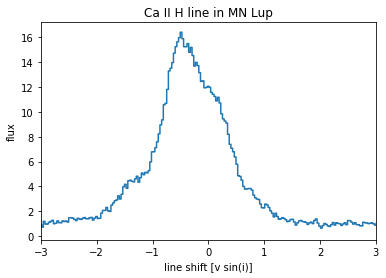

In [33]:
# set reasonable figsize for 1-column figures
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, fcaII[0,:], marker='', drawstyle='steps-mid')
ax.set_xlim([-3,+3])
ax.set_xlabel('line shift [v sin(i)]')
ax.set_ylabel('flux')
ax.set_title('Ca II H line in MN Lup')
# when using this interface, we need to explicitly call the draw routine
plt.draw()

### Exercise

The plot above shows only a single spectrum. Plot all spectra into a single
plot and introduce a sensible offset between them, so that we can follow
the time evolution of the line.

There are clearly several ways to produce a well-looking plot. Here is one
way:

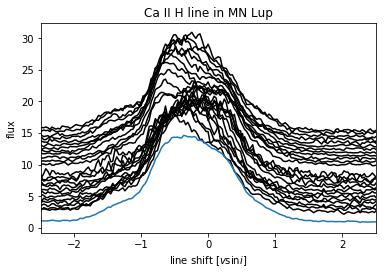

In [34]:
yshift = np.arange((fcaII.shape[0])) * 0.5
#shift the second night up by a little more
yshift[:] += 1.5
yshift[13:] += 1

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(25):
    ax.plot(x, fcaII[i,:]+yshift[i], 'k')

#separately show the mean line profile in a different color
ax.plot(x, np.mean(fcaII, axis =0))
ax.set_xlim([-2.5,+2.5])
ax.set_xlabel('line shift [$v \\sin i$]')
ax.set_ylabel('flux')
ax.set_title('Ca II H line in MN Lup')
fig.subplots_adjust(bottom = 0.15)
plt.draw()

Next, we'll make a more advanced plot. For each spectrum we calculate
the difference to the mean flux.

In [35]:
fmean = np.mean(fcaII, axis=0)
fdiff = fcaII - fmean[np.newaxis,:]

In the following simple plot, we can already see features moving through the line.
However, the axis scales are not right, the gap between both nights is not visible
and there is no proper labeling.

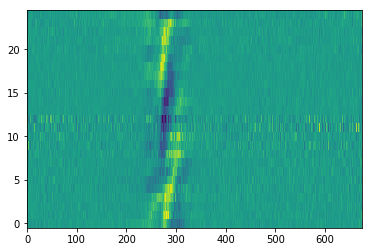

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(fdiff, aspect = "auto", origin = 'lower')

In the following, we'll plot the spectra from both nights separately.
Also, we'll pass the ``extent`` keyword to ``ax.imshow`` which takes care
of the axis.

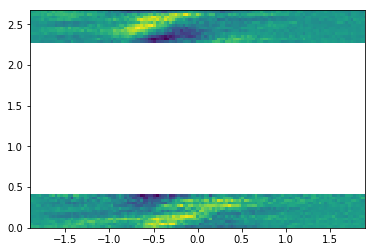

In [37]:
ind1 = delta_p < 1 * u.dimensionless_unscaled
ind2 = delta_p > 1 * u.dimensionless_unscaled

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ind in [ind1, ind2]:
    im = ax.imshow(fdiff[ind,:], extent = (np.min(x), np.max(x), np.min(delta_p[ind]), np.max(delta_p[ind])), aspect = "auto", origin = 'lower')

ax.set_ylim([np.min(delta_p), np.max(delta_p)])
ax.set_xlim([-1.9,1.9])
plt.draw()

Now, this plot is already much better, but there are still some things that can be
improved:

* Introduce an offset on the y-axis to reduce the amount of white space.
* Strictly speaking, the image shown is not quite the right scale because the
``extent`` keyword gives the edges of the image shown, while ``x`` and
``delta_p`` contain the bin mid-points.
* Use a gray scale instead of color to save publication charges.
* Add labels to the axis.

The following code addresses these points.

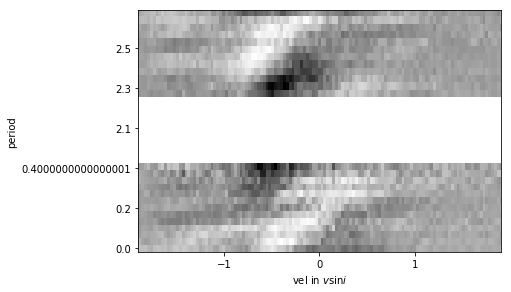

In [38]:
# shift a little for plotting purposes
pplot = delta_p.copy().value
pplot[ind2] -= 1.5
# image goes from x1 to x2, but really x1 should be middle of first pixel
delta_t = np.median(np.diff(delta_p))/2.
delta_x = np.median(np.diff(x))/2.
# imshow does the normalization for plotting really well, but here I do it
# by hand to ensure it goes -1,+1 (that makes color bar look good)
fdiff = fdiff / np.max(np.abs(fdiff))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ind in [ind1, ind2]:
    im = ax.imshow(fdiff[ind,:],
    extent = (np.min(x)-delta_x, np.max(x)+delta_x,
    np.min(pplot[ind])-delta_t, np.max(pplot[ind])+delta_t),
    aspect = "auto", origin = 'lower', cmap = plt.cm.Greys_r)

ax.set_ylim([np.min(pplot)-delta_t, np.max(pplot)+delta_t])
ax.set_xlim([-1.9,1.9])
ax.set_xlabel('vel in $v\\sin i$')
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

def pplot(y, pos):
    'The two args are the value and tick position'
    'Function to make tick labels look good.'
    if y < 0.5:
        yreal = y
    else:
        yreal = y + 1.5
    return yreal

formatter = plt.FuncFormatter(pplot)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('period')
fig.subplots_adjust(left = 0.15, bottom = 0.15, right = 0.99, top = 0.99)
plt.draw()

### Exercise

Understand the code for the last plot. Some of the commands used are
already pretty advanced stuff. Remember, any internet search engine can be
your friend.

Clearly, we didn't develop this code for scratch.
The [matplotlib gallery](http://matplotlib.org/gallery.html) is our
preferred place to look for plotting solutions.

## Contributing to Astropy

[Astropy](http://astropy.org) is an open-source and community-developed
Python package, which means that is only as good as the contribution of the
astronomical community. There will always people who have more fun writing
code and others who have more fun using it. However, if you find a bug and do not
report it, then it is unlikely to be fixed. If you wish for a specific feature,
then you can either implement it and contribute it or at least fill in a feature
request.

If you want to get help or discuss issues with other Astropy users, you can
sign up for the [astropy mailing list](http://mail.scipy.org/mailman/listinfo/astropy).
Alternatively, the [astropy-dev](http://groups.google.com/group/astropy-dev) list is where you should go to
discuss more technical aspects of Astropy with the developers.

If you have come across something that you believe is a bug, please open a
ticket in the Astropy [issue tracker](http://github.com/astropy/astropy/issues), and we will look into it
promptly.

Please try to include an example that demonstrates the issue and will allow the
developers to reproduce and fix the problem.  If you are seeing a crash
then frequently it will help to include the full Python stack trace as well as
information about your operating system (e.g. MacOSX version or Linux version).